In [40]:
# data wrangling
import numpy as np
import pandas as pd

# bayesian analysis
import pymc as pm
import arviz as az

# statistics
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt

In [4]:
sp500_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1177&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=SP500&scale=left&cosd=2015-11-27&coed=2025-11-25&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%20Close&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-26&revision_date=2025-11-26&nd=2015-11-27"

df = pd.read_csv(sp500_url).rename({"observation_date":"date"}, axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")

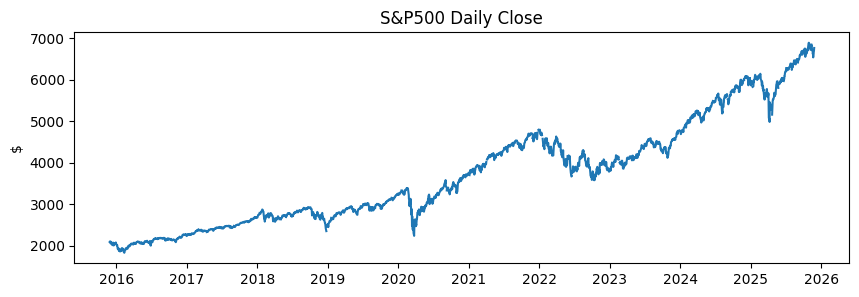

In [9]:
plt.figure(figsize=(10,3))
plt.plot(df)
plt.title("S&P500 Daily Close")
plt.ylabel("$")
plt.show()

In [ ]:
# understanding NA values -- MAR, MNAR?
df[df.isna()["SP500"]].head(10)

,SP500
date,
2015-12-25,NaN
2016-01-01,NaN
2016-01-18,NaN
2016-02-15,NaN
2016-03-25,NaN
2016-05-30,NaN
2016-07-04,NaN
2016-09-05,NaN
2016-11-24,NaN


In [26]:
# NA values are all holidays, no imputation necessary -> safe to drop.
df = df.dropna()

In [35]:
np.log(df).diff(1)

,SP500
date,
2015-11-27,NaN
2015-11-30,-0.004652
2015-12-01,0.010624
2015-12-02,-0.011057
2015-12-03,-0.014478
...,...
2025-11-19,0.003747
2025-11-20,-0.015690
2025-11-21,0.009775


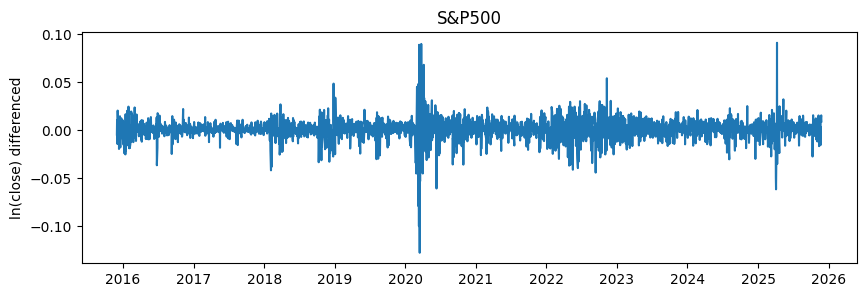

In [39]:
plt.figure(figsize=(10,3))
plt.plot(np.log(df).diff(1))
plt.title("S&P500")
plt.ylabel("ln(close) differenced")
plt.show()

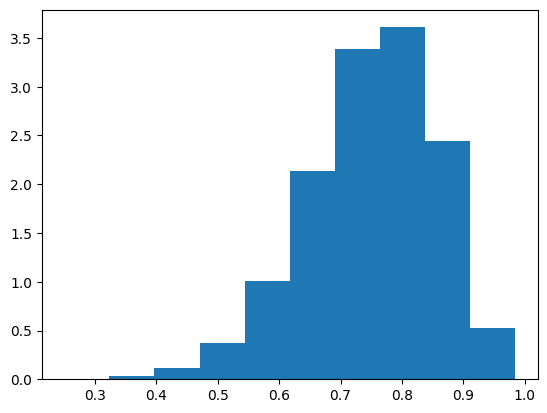

In [63]:
plt.hist(stats.beta(12,4).rvs(10000), density=True)
plt.show()

# Model 1: Differenced time series | Volitility Modeling

Let $Z \in \{0, 1\} $ be our latent state variable. 

**Priors**

$$ \tau^2 \sim \text{Gamma}(1, 1) $$

$$ \theta_j \sim \text{Gamma}(4, 1) $$

$$ \sigma_j^2 \sim \mathcal{N}(\theta_j, \tau^2) $$

$$ p \sim Beta(1,1) $$

**Sampling Model**

$$ Z_j \sim \text{Bernoulli}(p) $$

$$ Y_i | \theta, Z_j \sim \mathcal{N}(0, \sigma_j^2) $$




In [ ]:

# init params
# mean always = 0

with pm.model() as model:

    tau2 = pm.Gamma("tau2", 1,1)
    theta_1 = pm.Gamma("theta_1", 4, 1)
    theta_2 = pm.Gamma("theta_2", 4, 1)

    sigma2_1 = pm.Gamma("sigma2_1", theta_1, tau2)
    sigma2_2 = pm.Gamma("sigma2_2", theta_2, tau2)

    p = pm.Beta("p", 1, 1)

    # latent variable
    Z = pm.Bernoulli("Z", p, shape=len(df))
    sigma = pm.math.switch(Z, sigma2_1, sigma2_2)  # same shape as y, broadcasted

    Y = pm.Normal("Y", mu=0.0, sigma=sigma, observed=y)

    # sampling model




n_regimes = 2

with pm.model() as model:

    tau2 = pm.Gamma("tau2", 1,1)
    theta = pm.Gamma("theta", 4, 1, size = n_regimes)

    sigma2 = pm.Normal("sigma2", theta, tau2) # also broadcast to two vals?

    p = pm.Beta("p", 1, 1)

    # latent variable
    Z = pm.Bernoulli("Z", p, shape=len(df))
    regime_1_idx = Z==0

    # sampling model
    Y = pm.Normal(0, sigma2[regime_1_idx], observed = df)




,SP500
date,
2015-11-27,2090.11
2015-11-30,2080.41
2015-12-01,2102.63
2015-12-02,2079.51
2015-12-03,2049.62
...,...
2025-11-19,6642.16
2025-11-20,6538.76
2025-11-21,6602.99


Ideas:

# Smoothing vs Filtering:

$$ \text{Filtering: } p(x_t | y_1, ..., y_t, \Theta) $$
$$ \text{Smoothing: } p(x_t | y_1, ..., y_T, \Theta) $$
$$ \forall t \geq 0 \leq T $$

... but what if we develop filtering similar to convolutional Neural Nets, where it's a sliding window?